___One of the more important aspects of AB testing is explainability to stake-holders. How do you interpret your results? In order to do so, it is necessary to have a fundamental grasp of how the algorithm works.___

One of the most common methods of calculating significance in Controlled Online Experiments is __T-test__.

To reiterate from the previous chapter, T-test compares the mean of two difference samples with consideration to the variance of them, ultimately giving the significance of how different they are from each other. Welch's T-test differs from Student's T-test in the assumption of variances. Student's t-test assumes that the variance is the same for both the sample whereas Welch's T-test assumes unequal variances. Here we focus on independent samples T test meaning that the data we observe is from difference samples (no cross over or leakage) _more on this later_.

<u>__Student's T test:__</u>

<font size="6">$ t = \frac{\bar{X}_{1} - \bar{X}_{2} }{\sqrt{s^{2}({ \frac{1}{N_{1}} + \frac{1}{N_{2}})}}} $</font>

<u>__Welch's T test:__</u>

<font size="6">$ t = \frac{\bar{X}_{1} - \bar{X}_{2} }{\sqrt{\frac{s_{1}^{2}}{N_{1}} + \frac{s_{2}^{2}}{N_{2}}}} $</font>

where, <br>
- $\bar{X}$ =  sample mean
- $s$ = standard deviation
- $N$ = sample size


__Practically, Welch's T-test is just equal to Student's T-test if the variances are equal.__ Personally, I would use Welch's t-test just because it catches the error if the variances are not equal.

Intuitively, The larger the t score, the more difference there is between groups. The smaller the t score, the more similarity there is between groups.

Taking the example from last notebook,

In [15]:
import numpy as np
import random 
random.seed(30)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
          'figure.figsize': (12.5, 9),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

def generate_data(sample_number):
    revenue_per_user_range = np.arange(50, 100, 0.012)
    #Note THIS IS NOT the Randomization unit. I am just assigning 1000 'users' with random revenue-per-user quantities from the above list
    control = random.choices(revenue_per_user_range, k=sample_number)
    treatment = random.choices(revenue_per_user_range, k=sample_number)
    return control,treatment

control,treatment  = generate_data(1000)

In [7]:
control_mean = np.mean(control)
treatment_mean = np.mean(treatment)
control_stddev = np.std(control)
treatment_stddev = np.std(treatment)

N = 1000

In [8]:
t = (treatment_mean - control_mean)/ ( (control_stddev)**2/N + (treatment_stddev)**2/N )**1/2
t

1.3218037641607

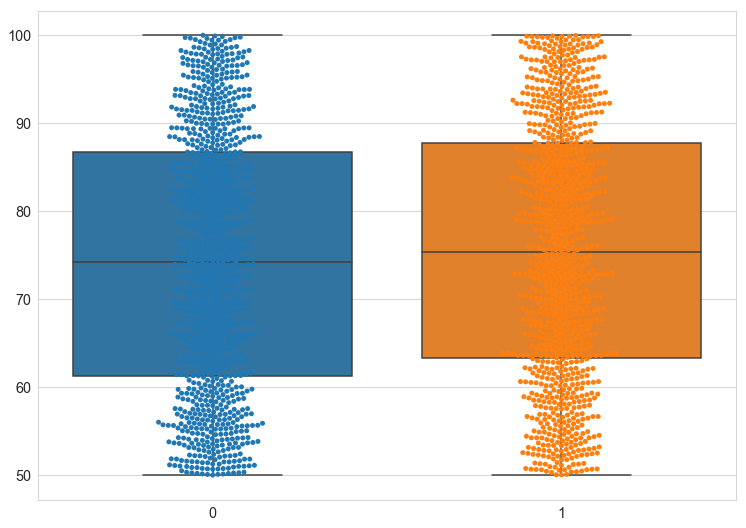

In [18]:
import seaborn as sns 
sns.set_style("whitegrid")

sns.boxplot(data = [control,treatment])
sns.swarmplot(data = [control,treatment])